# <U>Notebook Table Of Contents<u>
**1. Loading in datasets<br>**
**2. Cleaning spectral type labelling**<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.1 Miles Data<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.2 CFLIB Data<br>
**1. MLP classification**<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.1 Running initial baseline model (2 hidden layers)<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.2 Tuning number of layers<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.3 Tuning hyperparameters<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.4 Running Tuned MLP<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.5 PCA + MLP<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.6 Using Class Weights to handle Imbalance<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.7 Using Balanced Dataset<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.7.1 Tuning hyperparameters<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.7.2 Running Tuned MLP for balanced dataset<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.8 Running MLP using balanced dataset and 24 PCs<br>
**2. CNN multiclass classification**<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.1 Weight Balancing<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.2 Using Balanced Dataset<br>
**3. running stratified K-fold cross validation for NN model comparisons**<br>
**4. Saving CNN models**<br>

In [2]:
#!pip install keras-tuner

In [41]:
#importing pandas and numpy packages
import numpy as np
import pandas as pd

##importing plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 

#neural network libraries (keras/tensorflow)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.datasets import mnist
from keras.layers import  Conv1D, MaxPooling1D, Conv2D, MaxPool2D, Flatten
from keras import utils
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from scikeras.wrappers import KerasClassifier
from skopt import BayesSearchCV
from sklearn.decomposition import PCA
import keras_tuner as kt
from keras_tuner import BayesianOptimization

#sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import class_weight
from sklearn.model_selection import cross_val_score,KFold, StratifiedKFold

#supressing warnings
import warnings
warnings.filterwarnings('ignore')

Notes on Conv1D: https://www.tensorflow.org/api_docs/python/tf/nn/conv1d , https://keras.io/api/layers/convolution_layers/convolution1d/-- used for applying convolutions to 1D sequential data


In [4]:
##load in cleaned and processed data
main_class_data = pd.read_csv('../data/derived_tables/X_y_data/main_class_data.csv', index_col=0)

In [5]:
#splitting into independent/input (X) and dependent/target (Y) variables
X = main_class_data.loc[:, main_class_data.columns != 'main_class']
y = main_class_data.loc[:, 'main_class']

In [6]:
#converting to array of arrays to be compatible with CNN architecture
X = X.values

In [7]:
#saving a list of the distinct classes
class_order = set(y)
class_order

{0, 1, 2, 3, 4, 5, 6}

**The categorical values (i.e. target variables) need to be one hot encoded in order to work with Neural Networks for multiclass classification. - Frameworks like Keras require the labels to be binarized and have the same dimension as the number of classes.**

In [8]:
#one hot encoding y variable
y = np.array(y)
y = to_categorical(y)

#### Defining function to split training and testing data

In [9]:
def split_cnn_data(X, y):
    #splitting the data into training and testing (80% used for training, 20% for testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = 0.2,
                                                        random_state = 1, 
                                                        stratify = y)
    #reshaping X variables
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, X_test, y_train, y_test

#### Defining some functions to help removing repeated code when evaluating models:

In [10]:
#defining function for evaluating metrics 
def get_metrics(model, X_train, X_test, y_train, y_test):
    #making predictions from the model on the train and test data
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)

    #need to convert prediction probabilities to predicted classes
    y_preds_test = np.argmax(y_preds_test, axis=1)
    y_preds_train = np.argmax(y_preds_train, axis=1)
    
    #converting actual targets to classes from one hot encoded values
    y_test = np.argmax(y_test, axis=1)
    y_train = np.argmax(y_train, axis=1)

    #calculating metrics
    # F1-score
    test_f1 = metrics.f1_score(y_test, y_preds_test, average='weighted')
    train_f1 = metrics.f1_score(y_train, y_preds_train, average='weighted')
    #accuracy
    test_accuracy = metrics.accuracy_score(y_test, y_preds_test)
    train_accuracy =  metrics.accuracy_score(y_train, y_preds_train)

    #quadratic weighted kappa
    test_qwk = metrics.cohen_kappa_score(y_test, y_preds_test, weights='quadratic')
    train_qwk = metrics.cohen_kappa_score(y_train, y_preds_train, weights='quadratic')
    #mean absolute error
    test_mae = metrics.mean_absolute_error(y_test, y_preds_test)
    train_mae =  metrics.mean_absolute_error(y_train, y_preds_train)
    
    #getting the class error for test set
    average_error = np.mean(abs(y_test - y_preds_test))
    
    model_metrics = pd.DataFrame({'model':[str(model)], 
                                  'accuracy':[test_accuracy], 
                                  'f1_score':[test_f1],
                                  'QWK':[test_qwk], 
                                  'MAE':[test_mae],
                                   'sp_class_error':[average_error]})

    return model_metrics, y_preds_test, y_preds_train

In [11]:
def plot_confusion_matrix(y_test, y_pred, model_name):
    #plotting the confusion matrix
    confusion = metrics.confusion_matrix(y_test, y_pred)

    class_names=['O', 'B', 'A', 'F', 'G', 'K', 'M']

    fig, ax = plt.subplots()
    sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu" ,fmt='g',
                xticklabels=class_names,yticklabels=class_names,cbar=False)
    plt.title(f'Confusion matrix: {model_name}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show() 

--------
# 1. MLP classification

In [145]:
#splitting the data into training and testing (80% used for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 1, 
                                                    shuffle = True, 
                                                    stratify = y)

In [146]:
X_train.shape,  X_test.shape, y_train.shape, y_test.shape

((1744, 3508), (436, 3508), (1744, 7), (436, 7))

- The Multilayer perceptrons utilise Keras (a high-level API) which runs on top of TensorFlow (provides the computational backend for the constructed networks). <br>
- The model is initialized as an object from Tensorflows **sequential** class. This is utilized to create models in a linear layer-by-layer stack.<br>
- After initialising the model, each layer can be added in succession. Each layer is added as a *Dense* layer. This means that every neuron in the layer takes the input from all the other neurons of the previous layer.<br>


- Note that a **softmax** activation function was used in the output layer. This ensures the output values are in the range of 0 and 1 and may be used as predicted probabilities.

## 1.1 Running initial baseline model (2 hidden layers)

In [14]:
#initialising model as a Sequential model
ann_1 = Sequential()

#first hidden layer
ann_1.add(Dense(128, input_dim = (X_train.shape[1]), activation='relu'))

#second hidden layer
ann_1.add(Dense(128, activation='relu'))

#output layer with number of neurons corresponding to number of classes, softmax activation
ann_1.add(Dense(y_train.shape[1], activation='softmax'))

#compiling the model
ann_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
#fitting the model on to the training and testing data
model_history_1 = ann_1.fit(X_train, y_train, epochs=120, batch_size=80,  verbose=0) 

In [16]:
model_history_1.history.keys()

dict_keys(['loss', 'accuracy'])

In [17]:
ann1_metrics, y_preds_test_ann_1, y_preds_train_ann_1 = get_metrics(ann_1, 
                                                                    X_train, X_test, y_train, y_test)

14/14 [==============================] - 0s 2ms/step


In [113]:
ann1_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,<keras.src.engine.sequential.Sequential object...,0.844037,0.871012,0.962287,0.162844,0.162844


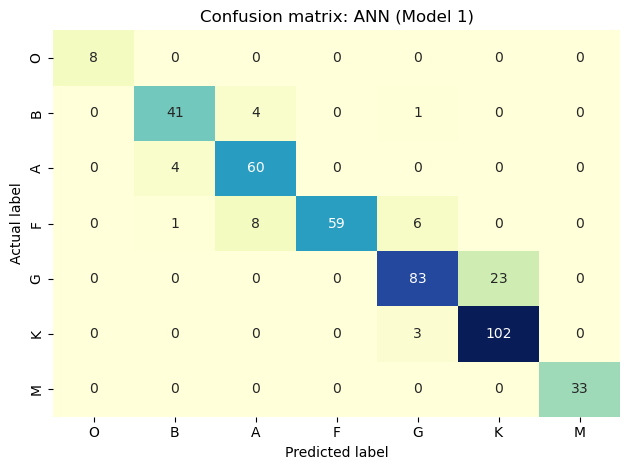

In [19]:
plot_confusion_matrix(np.argmax(y_test, axis=1), y_preds_test_ann_1, 'ANN (Model 1)')

## 1.2 Tuning number of layers

In [20]:
#defining function to tune layers
def run_ann(num_layers, X_train, y_train):
    #initialising model as a Sequential model
    model = Sequential()

    #first hidden layer
    model.add(Dense(128, input_dim = (X_train.shape[1]), activation='relu'))
    
    if num_layers == 2:
        model.add(Dense(64, activation='relu'))
    if num_layers == 3: 
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
    if num_layers == 4: 
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(16, activation='relu'))

    #output layer with number of neurons corresponding to number of classes, softmax activation
    model.add(Dense(y_train.shape[1] , activation='softmax'))

    #compiling the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

**Defining Function to get cross validation score of each ann model:**

In [30]:
def evaluate_ann_layers(num_layers, X, y):
    s_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

    train_acc, test_acc = [], []

    for train_index, test_index in s_kfold.split(X, np.argmax(y, axis=1)): 
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        #compiling the model
        model = run_ann(num_layers, X_train, y_train)
        #fitting the model
        model.fit(X_train, y_train, epochs=100, batch_size=100,  verbose=0)
        #evaluating the model
        train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        #appending results
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
    #returning the mean results
    train_acc = np.mean(train_acc)
    test_acc = np.mean(test_acc)
    print(f'training accuracy:{train_acc}')
    print(f'testing accuracy:{test_acc}')

In [31]:
#running for two hidden layers
evaluate_ann_layers(2, X, y)

training accuracy:0.8610140681266785
testing accuracy:0.8605455557505289


In [32]:
#running for three hidden layers
evaluate_ann_layers(3, X, y)

training accuracy:0.8745442032814026
testing accuracy:0.872478703657786


In [33]:
#running for four hidden layers
evaluate_ann_layers(4, X, y)

training accuracy:0.8055001894632975
testing accuracy:0.7913043101628622


**Therefore going with 3 hidden layer architecture**

## 1.3 Tuning hyperparameters 

Hyperparameters to be tuned: 
- hidden layer neurons
- batch_size
- optimizer
- activiation (hidden layer/output)
- epochs

In [34]:
#defining dictionary of hyperparams to be tuned
param_grid = {
    'layer_1':[64, 128, 256],
    'layer_2':[32, 64, 128],
    'layer_3':[16, 32, 64],
    'epochs':[100, 120, 140],
    'batch_size':[30, 60, 90, 120],
    'activation_1':['relu','leaky_relu','tanh'],
    'activation_2':['relu','leaky_relu','tanh'],
    'activation_3':['relu','leaky_relu','tanh'],
    'optimizer':['adam']}

In [35]:
## need to create a function for the ANN model 
def create_ANN(layer_1, layer_2, layer_3, input_dim, activation_1, activation_2, activation_3):
    #initialising model as a Sequential model
    model = Sequential()
    #first hidden layer
    model.add(Dense(layer_1, input_dim=input_dim, activation=activation_1))
    #second hidden layer
    model.add(Dense(layer_2, activation=activation_2))
    #third hidden layer
    model.add(Dense(layer_3, activation=activation_3))
    
    #output layer
    model.add(Dense(y_train.shape[1], activation='softmax'))
    #compiling the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

The below wrapper class (KerasClassifier) provided by scikeras enables keras models to be used as if it were a scikit-learn classifier, enabling BayesSearchCV 

reference: https://pypi.org/project/scikeras/0.1.8/

In [36]:
#creating wrapper around the keras model feeding the parameter space
keras_class = KerasClassifier(model=create_ANN,
                              layer_1=param_grid['layer_1'],
                              layer_2=param_grid['layer_2'],
                              layer_3=param_grid['layer_3'],
                              input_dim=X_train.shape[1],
                              activation_1=param_grid['activation_1'],
                              activation_2=param_grid['activation_2'],
                              activation_3=param_grid['activation_3'],
                              verbose=0)

In [37]:
#Using Bayesian Optimisation for hyperparameter tuning due to the computational time required for tuning all hyperparams
bayesSearch = BayesSearchCV(
 estimator=keras_class,
 search_spaces=param_grid,
 scoring='accuracy',
 cv=3,
 n_iter=50,
)

In [38]:
#splitting the data into training and testing (80% used for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 1, 
                                                    shuffle = True, 
                                                    stratify = y)

In [39]:
bayesSearch.fit(X_train, y_train)

In [40]:
print(bayesSearch.best_params_)

OrderedDict([('batch_size', 80), ('epochs', 140), ('activation_1', 'relu'), ('activation_2', 'relu'), ('activation_2', 'relu'), ('layer_1', 128), ('layer_2', 128), ('layer_3', 64), ('optimizer', 'adam')])


## 1.4 Running Tuned MLP

In [41]:
#initialising ann model with tunedhyperparams
ann_2 = create_ANN(layer_1=128,
                   layer_2=128,
                   layer_3=64,
                   input_dim=X_train.shape[1],
                   activation_1='relu',
                   activation_2='relu',
                   activation_3='relu'
                   )

In [42]:
#fitting the model on to the training and testing data
model_history_2 = ann_2.fit(X_train, y_train, epochs=140, batch_size=80,  verbose=0) 

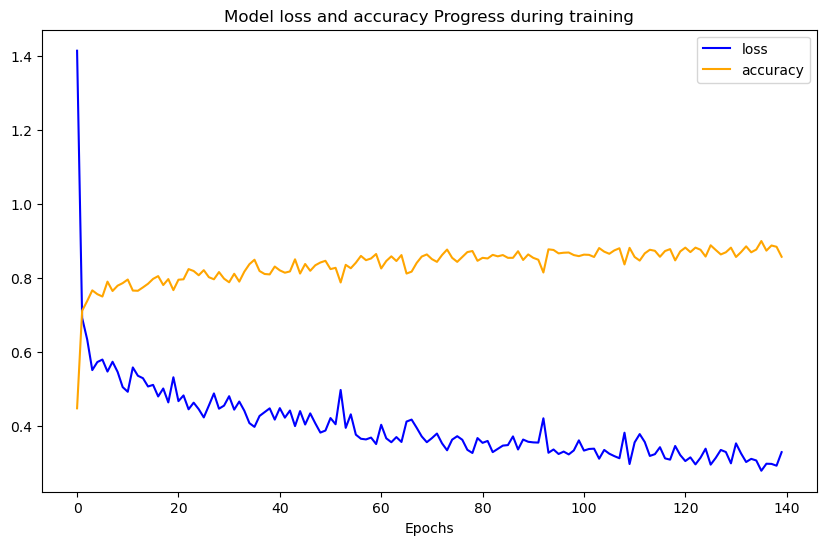

In [43]:
#plotting the loss as a function of number of epochs to visualise how the model is learning
plt.figure(figsize=(10,6))
plt.plot(model_history_2.history['loss'], color='blue',label='loss')
plt.plot(model_history_2.history['accuracy'], color='orange',label='accuracy')
plt.title('Model loss and accuracy Progress during training')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [44]:
ann2_metrics, y_preds_test_ann_2, y_preds_train_ann_2 = get_metrics(ann_2, 
                                                      X_train, X_test, y_train, y_test)

14/14 [==============================] - 0s 2ms/step


In [114]:
ann2_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,<keras.src.engine.sequential.Sequential object...,0.894495,0.908161,0.971722,0.112385,0.112385


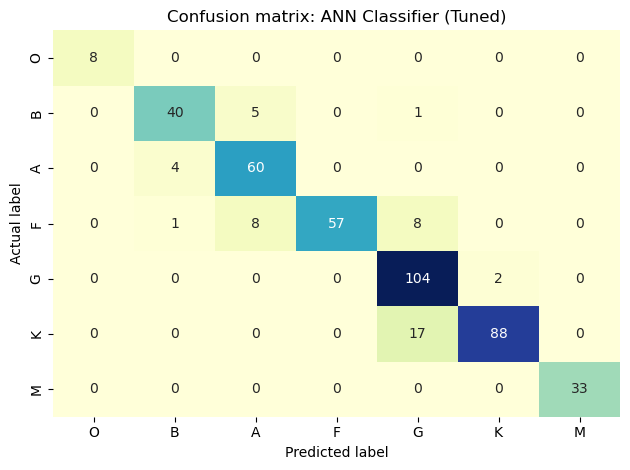

In [46]:
plot_confusion_matrix(np.argmax(y_test, axis=1), y_preds_test_ann_2, 'ANN Classifier (Tuned)')

In [137]:
#defining function for running tuned mlp
def run_mlp(X_train, X_test, y_train, y_test):
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    #output layer
    model.add(Dense(y_train.shape[1], activation='softmax'))
    #compiling the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #fitting the model on to the training and testing data
    model_history = model.fit(X_train, y_train, epochs=120, batch_size=80,  verbose=0)
    return model, model_history

## 1.5 PCA  + MLP

**using 24 principal components from data as determined from ML_Main_Class_Classification.ipynb**

In [163]:
#using 24 principal components
#setting n_components at None includes all principal components
pca = PCA(n_components=24)

In [164]:
X_pca = pca.fit_transform(X)

In [149]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [151]:
compression_ratio = 100 - ((X_train_pca.shape[1]) / (X_train.shape[1]))*100
print(f'training data reduced by {compression_ratio:.4f}% after PCA applied')

training data reduced by 99.3158% after PCA applied


In [52]:
#initialising ann model with tunedhyperparams
ann_pca = create_ANN(layer_1=128,
                   layer_2=128,
                   layer_3=64,
                   input_dim=X_train_pca.shape[1],
                   activation_1='relu',
                   activation_2='relu',
                   activation_3='relu'
                   )

#fitting the model on to the training and testing data
ann_pca.fit(X_train_pca, y_train, epochs=140, batch_size=80,  verbose=0) 

In [53]:
ann_pca_metrics, y_preds_test_ann_pca, y_preds_train_ann_pca = get_metrics(ann_pca,
                                                          X_train_pca, X_test_pca, y_train, y_test)

14/14 [==============================] - 0s 2ms/step


In [116]:
ann_pca_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,<keras.src.engine.sequential.Sequential object...,0.901376,0.903819,0.973426,0.105505,0.105505


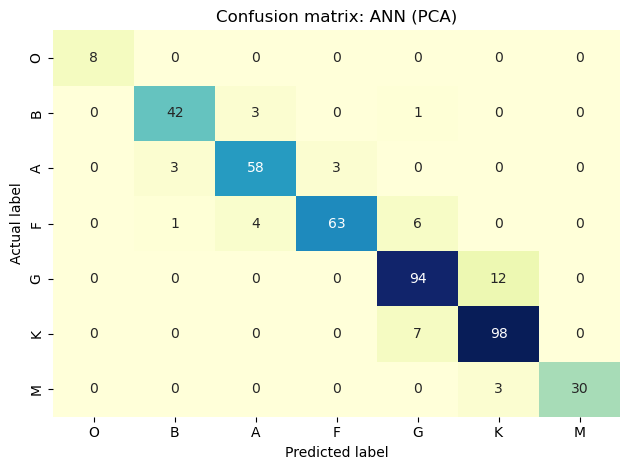

In [55]:
plot_confusion_matrix(np.argmax(y_test, axis=1), y_preds_test_ann_pca, 'ANN (PCA)')

## 1.6 Using Class Weights to handle Imbalance

In [56]:
#creating weights for each class so that they are "balanced" (the smaller a class is the larger the weight)
class_weights = class_weight.compute_class_weight('balanced',
                                                   classes = np.unique(np.argmax(y_train,axis=1)),
                                                   y = np.argmax(y_train,axis=1))

In [57]:
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 8.304761904761905,
 1: 1.3394777265745008,
 2: 0.9656699889258029,
 3: 0.8445520581113801,
 4: 0.586218487394958,
 5: 0.5960355434039645,
 6: 1.8874458874458875}

In [58]:
#initialising ann model with tunedhyperparams
ann_cl_weight = create_ANN(layer_1=128,
                   layer_2=128,
                   layer_3=64,
                   input_dim=X_train.shape[1],
                   activation_1='relu',
                   activation_2='relu',
                   activation_3='relu',
                   )

In [59]:
#fitting the model on to the training and testing data
ann_cl_weight.fit(X_train, y_train, epochs=140, batch_size=80,  verbose=0, class_weight=class_weight_dict) 

In [60]:
ann_cl_weights_metrics, y_preds_test_ann_weights, y_preds_train_ann_weights = get_metrics(ann_cl_weight,
                                                                  X_train, X_test, y_train, y_test)

14/14 [==============================] - 0s 2ms/step


In [118]:
ann_cl_weights_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,<keras.src.engine.sequential.Sequential object...,0.876147,0.881065,0.968897,0.130734,0.130734


## 1.7 Using Balanced Dataset
Note: using optimised number of layers from imbalanced dataset

In [62]:
##load in cleaned and processed balanced data
balanced_df = pd.read_csv('../data/derived_tables/X_y_data/main_bal.csv', index_col=0)

In [63]:
#splitting into independent/input (X) and dependent/target (Y) variables
X_bal = balanced_df.loc[:, balanced_df.columns != 'main_class']
y_bal = balanced_df.loc[:, 'main_class']

In [64]:
y_bal = y_bal.values
X_bal = X_bal.values

#one hot encoding y variable
y_bal = np.array(y_bal)
y_bal = to_categorical(y_bal)

In [65]:
#splitting the data into training and testing (80% used for training, 20% for testing)
X_train_bal, X_test_bal, y_train_bal, y_test_bal =  train_test_split(X_bal, y_bal, 
                                                                    test_size = 0.2,
                                                                    random_state = 1)

In [66]:
#looking at shapes
X_train_bal.shape, X_test_bal.shape, y_train_bal.shape, y_test_bal.shape

((1736, 3508), (434, 3508), (1736, 7), (434, 7))

### 1.7.1 Tuning hyperparameters 

Hyperparameters to be tuned: 
- hidden layer neurons
- batch_size
- optimizer
- activiation (hidden layer/output)
- epochs

In [67]:
#defining dictionary of hyperparams to be tuned
param_grid = {
    'layer_1':[64, 128],
    'layer_2':[32, 64, 128],
    'layer_3':[16, 32, 64],
    'epochs':[100, 120, 140],
    'batch_size':[30, 60, 90, 120],
    'activation_1':['relu','leaky_relu', 'tanh'],
    'activation_2':['relu','leaky_relu', 'tanh'],
    'activation_3':['relu','leaky_relu','tanh'],
    'optimizer':['adam']}

In [68]:
## need to create a function for the ANN model 
def create_ANN(layer_1, layer_2, layer_3, input_dim, activation_1, activation_2, activation_3):
    #initialising model as a Sequential model
    model = Sequential()
    #first hidden layer
    model.add(Dense(layer_1, input_dim=input_dim, activation=activation_1))
    #second hidden layer
    model.add(Dense(layer_2, activation=activation_2))
    #third hidden layer
    model.add(Dense(layer_3, activation=activation_3))
    
    #output layer
    model.add(Dense(7, activation='softmax'))
    #compiling the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

The below wrapper class (KerasClassifier) provided by scikeras enables keras models to be used as if it were a scikit-learn classifier, enabling BayesSearchCV 

reference: https://pypi.org/project/scikeras/0.1.8/

In [69]:
#creating wrapper around the keras model feeding the parameter space
keras_class = KerasClassifier(model=create_ANN,
                              layer_1=param_grid['layer_1'],
                              layer_2=param_grid['layer_2'],
                              layer_3=param_grid['layer_3'],
                              input_dim=X_train_bal.shape[1],
                              activation_1=param_grid['activation_1'],
                              activation_2=param_grid['activation_2'],
                              activation_3=param_grid['activation_3'],
                              verbose=0)

In [70]:
#Using Bayesian Optimisation for hyperparameter tuning due to the computational time required for tuning all hyperparams
bayesSearch = BayesSearchCV(
 estimator=keras_class,
 search_spaces=param_grid,
 scoring='accuracy',
 cv=3,
 n_iter=50,
)

In [112]:
bayesSearch.fit(X_train_bal, y_train_bal)

In [113]:
print(bayesSearch.best_params_)

OrderedDict([('batch_size', 80), ('epochs', 140), ('activation_1', 'relu'), ('activation_2', 'relu'), ('activation_2', 'relu'), ('layer_1', 128), ('layer_2', 128), ('layer_3', 64), ('optimizer', 'adam')])


### 1.7.2 Running Tuned MLP for balanced dataset

In [71]:
#initialising ann model with tunedhyperparams
ann_bal = create_ANN(layer_1=128,
                   layer_2=128,
                   layer_3=64,
                   input_dim=X_train_bal.shape[1],
                   activation_1='relu',
                   activation_2='relu',
                   activation_3='relu'
                   )

In [72]:
#fitting the model on to the training and testing data
model_history_bal = ann_bal.fit(X_train_bal, y_train_bal, epochs=140, batch_size=80,  verbose=0) 

In [73]:
annbal_metrics, y_preds_test_ann_bal, y_preds_train_ann_bal = get_metrics(ann_bal, 
                                                                          X_train, X_test, y_train, y_test)

14/14 [==============================] - 0s 2ms/step


In [9]:
annbal_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,<keras.src.engine.sequential.Sequential object...,0.892202,0.900898,0.970936,0.114679,0.114679


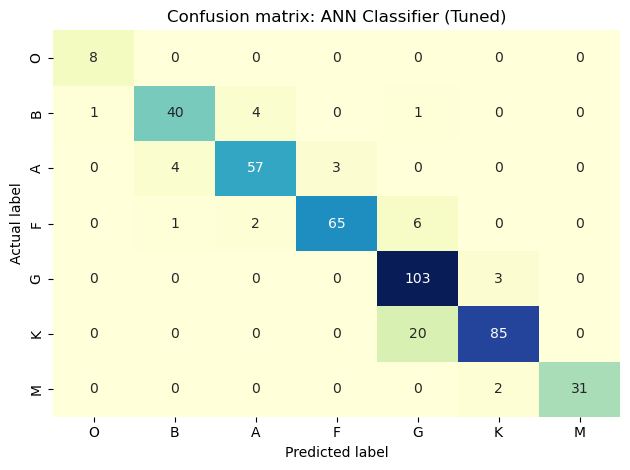

In [76]:
plot_confusion_matrix(np.argmax(y_test, axis=1), y_preds_test_ann_bal, 'ANN Classifier (Tuned)')

In [138]:
#defining function for running balanced dataset mlp
def run_mlp_bal(X_train, X_test, y_train, y_test):
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    #output layer
    model.add(Dense(y_train.shape[1], activation='softmax'))
    #compiling the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #fitting the model on to the training and testing data
    model_history = model.fit(X_train, y_train, epochs=120, batch_size=80,  verbose=0)
    return model, model_history

### 1.9 Running MLP using balanced dataset and 24 PCs

In [163]:
#using 24 principal components
#setting n_components at None includes all principal components
pca = PCA(n_components=24)

In [164]:
X_pca_bal = pca.fit_transform(X_bal)

In [149]:
X_train_pca_bal = pca.fit_transform(X_train_bal)
X_test_pca_bal = pca.transform(X_test_bal)

In [52]:
#initialising ann model with tunedhyperparams
ann_pca_bal = create_ANN(layer_1=128,
                   layer_2=128,
                   layer_3=64,
                   input_dim=X_train_pca.shape[1],
                   activation_1='relu',
                   activation_2='relu',
                   activation_3='relu'
                   )

#fitting the model on to the training and testing data
ann_pca_bal.fit(X_train_pca_bal, y_train, epochs=140, batch_size=80,  verbose=0) 

--------
# 2. CNN multiclass classification

In [12]:
#splitting the training/testing data
X_train, X_test, y_train, y_test = split_cnn_data(X, y)

**NOTE**: the notebook *CNN_Tuning.ipynb* Section 1 using google colab was used to tune the CNN architecture and hyperparameters resulting in the below model:

- CNN layer 1: filters = 32, kernel = 3, strides = 1, activation = relu
- CNN layer 2: filters = 64, kernel = 5, strides = 2, activation = relu
- maxpooling size = 2
- Dense layer = 128 neurons
- optimizer = Adam
- learning rate = 0.001 (default)
- batch size = 32

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1744, 3508, 1), (1744, 7), (436, 3508, 1), (436, 7))

In [14]:
def run_cnn(X_train, X_test, y_train, y_test):
    model = models.Sequential()
    model.add(Conv1D(32, kernel_size=3, strides=1, padding='valid', activation='relu', input_shape=(X_test.shape[1], 1)))
    model.add(layers.Conv1D(64,  kernel_size=5, strides=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    #Flatten output of conv
    model.add(layers.Flatten())

    # Fully connected Network as classifier
    # Hidden layer with tunable number of units
    model.add(Dense(128, activation='relu'))

    # Output layer
    model.add(layers.Dense(y_train.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    #setting early stopping to halt epochs if model has reached max accuracy
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)

    model_history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0,
                              validation_data=(X_test, y_test), callbacks=[early_stopping_cb])
    return model, model_history

In [15]:
cnn_model_main, model_history = run_cnn(X_train, X_test, y_train, y_test)

In [16]:
cnn_metrics, y_preds_test_cnn, y_preds_train_cnn = get_metrics(cnn_model_main, X_train, X_test, y_train, y_test)

14/14 [==============================] - 0s 16ms/step


In [11]:
cnn_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,<keras.src.engine.sequential.Sequential object...,0.917431,0.917973,0.982287,0.082569,0.082569


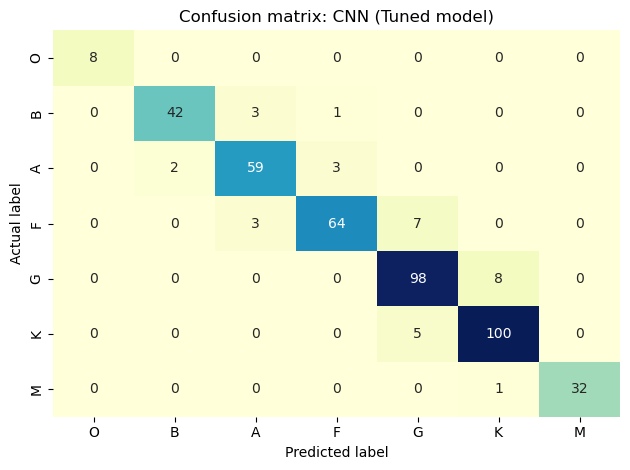

In [17]:
plot_confusion_matrix(np.argmax(y_test, axis=1), y_preds_test_cnn, 'CNN (Tuned model)')

In [18]:
#saving model in CNN directory to remove necessity to retrain model
#model.save('saved_models/CNNModel_1.h5')

# 2.1 Weight Balancing

In [92]:
#creating weights for each class so that they are "balanced" (the smaller a class is the larger the weight)
class_weights = class_weight.compute_class_weight('balanced',
                                                   classes = np.unique(np.argmax(y_train,axis=1)),
                                                   y = np.argmax(y_train,axis=1))

In [93]:
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 8.304761904761905,
 1: 1.3394777265745008,
 2: 0.9656699889258029,
 3: 0.8445520581113801,
 4: 0.586218487394958,
 5: 0.5960355434039645,
 6: 1.8874458874458875}

In [94]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1744, 3508, 1), (1744, 7), (436, 3508, 1), (436, 7))

In [95]:
model = models.Sequential()
model.add(Conv1D(32, kernel_size=3, strides=1, padding='valid', activation='tanh', input_shape=(X_test.shape[1], 1)))
model.add(layers.Conv1D(64,  kernel_size=5, strides=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

#Flatten output of conv
model.add(layers.Flatten())

# Fully connected Network as classifier
# Hidden layer with tunable number of units
model.add(Dense(128, activation='relu'))

# Output layer
model.add(layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

#setting early stopping to halt epochs if model has reached max accuracy
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

model_history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0,
                      validation_data=(X_test, y_test), callbacks=[early_stopping_cb],
                      class_weight=class_weight_dict)

In [96]:
cnn_cl_weights_metrics, y_preds_test_cnn, y_preds_train_cnn = get_metrics(model, X_train, X_test,
                                                                          y_train, y_test)

14/14 [==============================] - 0s 19ms/step


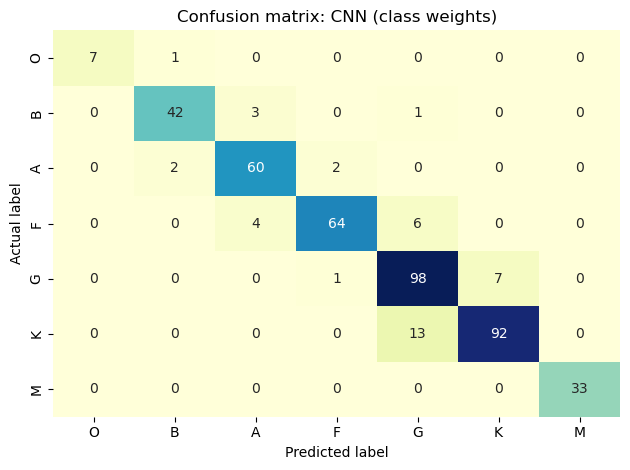

In [97]:
plot_confusion_matrix(np.argmax(y_test, axis=1), y_preds_test_cnn, 'CNN (class weights)')

## 2.2 Using Balanced Dataset

In [13]:
##load in cleaned and processed balanced data
balanced_df = pd.read_csv('../data/derived_tables/X_y_data/main_bal.csv', index_col=0)

In [14]:
#splitting into independent/input (X) and dependent/target (Y) variables
X_bal = balanced_df.loc[:, balanced_df.columns != 'main_class']
y_bal = balanced_df.loc[:, 'main_class']

In [15]:
y_bal = y_bal.values
X_bal = X_bal.values

#one hot encoding y variable
y_bal = np.array(y_bal)
y_bal = to_categorical(y_bal)

In [16]:
#splitting the data into training and testing (80% used for training, 20% for testing)
X_train_bal, X_test_bal, y_train_bal, y_test_bal =  train_test_split(X_bal, y_bal, 
                                                                    test_size = 0.2,
                                                                    random_state = 1)
#reshaping X variables
X_train_bal = X_train_bal.reshape((X_train_bal.shape[0], X_train_bal.shape[1], 1))
X_test_bal = X_test_bal.reshape((X_test_bal.shape[0], X_test_bal.shape[1], 1))  

In [17]:
#looking at shapes
X_train_bal.shape, X_test_bal.shape, y_train_bal.shape, y_test_bal.shape

((1736, 3508, 1), (434, 3508, 1), (1736, 7), (434, 7))

**NOTE**: the notebook *CNN_Tuning.ipynb* Section 1 using google colab was used to tune the CNN architecture and hyperparameters resulting in the below model:

Therefore best model for CNN main class classification is:
- layer 1: filters = 32, kernel = 3, strides = 1, activation = relu
- maxpooling size = 2
- layer 2: filters = 64, kernel = 5, strides = 2, activation = relu
- maxpooling size = 2
- 3 Dense layer = 128 neurons, 64 neurons, 64 neurons
- optimizer = Adam
- learning rate = 0.001 (default)
- batch size = 32


In [18]:
def run_cnn_bal(X_train, X_test, y_train, y_test):
    model = models.Sequential()
    model.add(Conv1D(32, kernel_size=3, strides=1, padding='valid', activation='relu', input_shape=(X_test.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(64,  kernel_size=5, strides=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    #Flatten output of conv
    model.add(layers.Flatten())

    # Fully connected Network as classifier
    # Hidden layer with tunable number of units
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))

    # Output layer
    model.add(layers.Dense(y_train.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    #setting early stopping to halt epochs if model has reached max accuracy
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)

    model_history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0,
                              validation_data=(X_test, y_test), callbacks=[early_stopping_cb])
    return model, model_history

In [20]:
#running model with balanced data
cnn_model_main_bal, model_history = run_cnn_bal(X_train_bal, X_test_bal, y_train_bal, y_test_bal)

In [22]:
cnn_bal_metrics, y_preds_test_cnn, y_preds_train_cnn = get_metrics(cnn_model_main_bal,
                                                  X_train_bal, X_test, y_train_bal, y_test)

14/14 [==============================] - 0s 33ms/step


In [13]:
cnn_bal_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,<keras.src.engine.sequential.Sequential object...,0.93578,0.937238,0.986294,0.06422,0.06422


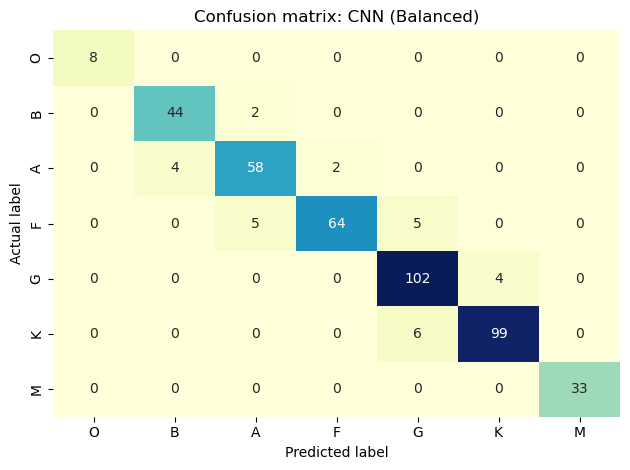

In [24]:
plot_confusion_matrix(np.argmax(y_test, axis=1), y_preds_test_cnn, 'CNN (Balanced)')

In [40]:
len(model_history.history['accuracy'])

48

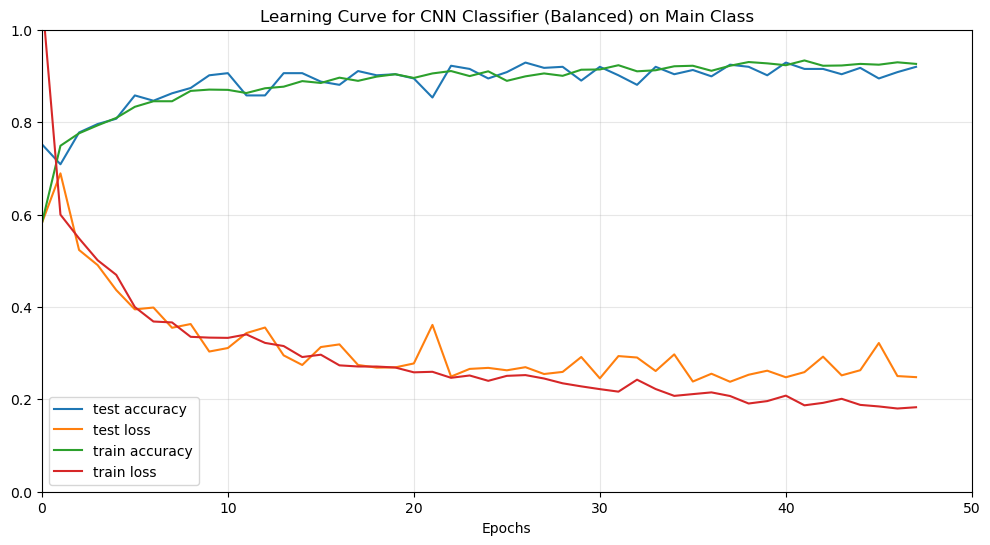

In [39]:
#plotting the loss/accuracies
plt.figure(figsize=(12,6))
plt.plot(model_history.history['val_accuracy'], label='test accuracy')
plt.plot(model_history.history['val_loss'], label='test loss')
plt.plot(model_history.history['accuracy'], label='train accuracy')
plt.plot(model_history.history['loss'], label='train loss')
plt.grid(True, alpha=0.3)
plt.xlabel('Epochs')
plt.title('Learning Curve for CNN Classifier (Balanced) on Main Class')
plt.legend()
plt.ylim(0,1)
plt.xlim(0,50)
plt.show()

# 3. running stratified K-fold cross validation for NN model comparisons

In [161]:
def get_cross_val_score(model_name, X, y):
    s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    f1, accuracy, qwk, mae, average_error = [], [], [], [], []
    
    #creating the train/test split
    for train_index, test_index in s_kfold.split(X, np.argmax(y,axis=1)):

        
        #splitting X and y
        X_train, X_test, y_train, y_test  = X[train_index], X[test_index], y[train_index], y[test_index]
        #changin X_train/X_test based on models
        if model_name[:3]=='cnn':
            #reshaping X variables to be compatible with CNNs
            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
            X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
            
        #initialising models
        if model_name == 'cnn':
            model, model_history = run_cnn(X_train, X_test, y_train, y_test) 
        elif model_name == 'cnn_bal':
            model, model_history = run_cnn_bal(X_train, X_test, y_train, y_test)
        elif model_name == 'mlp':
            model, model_history = run_mlp(X_train, X_test, y_train, y_test) 
        elif model_name == 'mlp_bal':   
            model, model_history = run_mlp_bal(X_train, X_test, y_train, y_test) 
        elif model_name == 'mlp_pca':   
            model, model_history = run_mlp(X_train, X_test, y_train, y_test)  
        elif model_name == 'mlp_bal_pca':   
            model, model_history = run_mlp(X_train, X_test, y_train, y_test)  
                   
        #making predictions from the model on the train and test data
        y_preds_train = model.predict(X_train)
        y_preds_test = model.predict(X_test)

        #need to convert prediction probabilities to predicted classes
        y_preds_train = np.argmax(y_preds_train, axis=1)
        y_preds_test = np.argmax(y_preds_test, axis=1)

        # Convert one-hot encoded variables back to categorical labels
        y_train = np.argmax(y_train, axis=1)
        y_test = np.argmax(y_test, axis=1)
    
        #calculating metrics
            # F1-score
        f1.append(metrics.f1_score(y_test, y_preds_test, average='weighted'))
        #accuracy
        accuracy.append(metrics.accuracy_score(y_test, y_preds_test))
        #quadratic weighted kappa
        qwk.append(metrics.cohen_kappa_score(y_test, y_preds_test, weights='quadratic'))
        #mean absolute error
        mae.append(metrics.mean_absolute_error(y_test, y_preds_test))
        #getting the class error for test set
        average_error.append(np.mean(abs(y_test - y_preds_test)))
        
    
    model_metrics = pd.DataFrame({'model':[model_name], 
                                  'accuracy':[np.mean(accuracy)], 
                                  'f1_score':[np.mean(f1)],
                                  'QWK':[np.mean(qwk)], 
                                  'MAE':[np.mean(mae)],
                                  'sp_class_error':[np.mean(average_error)]})
    return model_metrics

In [170]:
#running for all mlp models
mlp_df = get_cross_val_score('mlp', X, y)
mlp_pca_df = get_cross_val_score('mlp_pca', X_pca, y)
mlp_bal_df = get_cross_val_score('mlp_bal', X_bal, y_bal)
mlp_bal_pca_df = get_cross_val_score('mlp_bal_pca', X_bal_pca, y_bal)

23/23 [==============================] - 0s 1ms/step


In [173]:
#running for all cnn models
cnn_df = get_cross_val_score('cnn', X, y)
cnn_bal_df = get_cross_val_score('cnn_bal', X_bal, y_bal)

23/23 [==============================] - 1s 42ms/step


In [120]:
nn_comparison_df = pd.concat([mlp_df, mlp_pca_df, mlp_bal_df, mlp_bal_pca_df,
                              cnn_df, cnn_bal_df])
nn_comparison_df = ml_comparison_df.reset_index().drop(columns=['index'])

In [119]:
nn_comparison_df

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,mlp,0.847241,0.860171,0.965598,0.155511,0.155511
1,mlp_pca,0.892365,0.901315,0.976213,0.102743,0.102743
2,mlp_bal,0.845159,0.850035,0.979773,0.158067,0.158067
3,mlp_bal_pca,0.899009,0.904673,0.978323,0.101443,0.101443
4,cnn,0.912667,0.913977,0.978132,0.094626,0.094626
5,cnn_bal,0.938569,0.938362,0.989441,0.072735,0.072735


In [121]:
nn_comparison_df.to_csv('../data/derived_tables/model_comparisons/nn_main_class.csv')

# 4. Saving CNN models:

In [35]:
cnn_model_main.save('saved_models/cnn_model_main.h5')
cnn_model_main_bal.save('saved_models/cnn_model_main_bal.h5')